# Film recommender
Lesson 7 - Student 211039312
Danilo Carvalho Antunes
Github: Danilo-Carvalho-Antunes
Introduction
The main objetive of it is to create a model of Collaborative Filtering capable of predicting the movies a user might like to wacth base on previus ratings.
This notebook is based on Jeremy Howard's FastAi course in 2022
For the seventh lesson

# Import dependecies and the Data Set

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.pyplot as plt
import seaborn as sns
set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = Path('/kaggle/input/movie-recommendation-system')

In [3]:
ratings = pd.read_csv(path/'ratings.csv', header=None,
                      names=['userId','movieId','rating','timestamp'])
ratings.head()

/tmp/ipykernel_47/2211913770.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv(path/'ratings.csv', header=None,


,userId,movieId,rating,timestamp
0,userId,movieId,rating,timestamp
1,1,169,2.5,1204927694
2,1,2471,3.0,1204927438
3,1,48516,5.0,1204927435
4,2,2571,3.5,1436165433


# Analyzing the Data Set

In [4]:
ratings.shape

(22884378, 4)

In [5]:
ratings.describe()

,userId,movieId,rating,timestamp
count,22884378,22884378,22884378.0,22884378
unique,247755,43622,21.0,17770415
top,185430,356,4.0,825638400
freq,9281,80812,6231877.0,685


In [6]:
movies = movies = pd.read_csv(path/'movies.csv', encoding='latin-1',
                     usecols=(0,1), names=('movieId','title'), header=None)
movies.head()

,movieId,title
0,movieId,title
1,1,Toy Story (1995)
2,2,Jumanji (1995)
3,3,Grumpier Old Men (1995)
4,4,Waiting to Exhale (1995)


In [7]:
movies.shape

(34209, 2)

In [8]:
movies.describe()

,movieId,title
count,34209,34209
unique,34209,34186
top,movieId,War of the Worlds (2005)
freq,1,2


In [9]:
ratings = ratings.merge(movies)
ratings.head()

,userId,movieId,rating,timestamp,title
0,userId,movieId,rating,timestamp,title
1,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995)
2,13,169,1.0,974868393,Free Willy 2: The Adventure Home (1995)
3,14,169,3.0,845470321,Free Willy 2: The Adventure Home (1995)
4,17,169,1.0,944991371,Free Willy 2: The Adventure Home (1995)


In [10]:
ratings = ratings.drop(ratings.index[0])
ratings = ratings.reset_index(drop=True)

In [11]:
ratings.shape

(131071, 5)

In [12]:
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995)
1,13,169,1.0,974868393,Free Willy 2: The Adventure Home (1995)
2,14,169,3.0,845470321,Free Willy 2: The Adventure Home (1995)
3,17,169,1.0,944991371,Free Willy 2: The Adventure Home (1995)
4,68,169,1.0,1011092044,Free Willy 2: The Adventure Home (1995)


In [38]:
seed = 42
data = ratings.sample(100000,random_state=seed)

In [39]:
data.head()

,userId,movieId,rating,timestamp,title
112912,340,77455,4.0,1438577557,Exit Through the Gift Shop (2010)
19482,1337,1196,4.5,1415903010,Star Wars: Episode V - The Empire Strikes Back (1980)
71122,998,1103,3.0,945790020,Rebel Without a Cause (1955)
29334,432,150,3.5,1075441973,Apollo 13 (1995)
109823,1130,56757,2.5,1246793990,Sweeney Todd: The Demon Barber of Fleet Street (2007)


In [40]:
data.describe()

,userId,movieId,rating,timestamp,title
count,100000,100000,100000,100000,100000
unique,1437,9192,10,83224,9190
top,815,296,4.0,828193195,Pulp Fiction (1994)
freq,3845,373,25794,31,373


In [41]:
data['rating'] = pd.to_numeric(data['rating']).astype(int)

In [42]:
data.head()

,userId,movieId,rating,timestamp,title
112912,340,77455,4,1438577557,Exit Through the Gift Shop (2010)
19482,1337,1196,4,1415903010,Star Wars: Episode V - The Empire Strikes Back (1980)
71122,998,1103,3,945790020,Rebel Without a Cause (1955)
29334,432,150,3,1075441973,Apollo 13 (1995)
109823,1130,56757,2,1246793990,Sweeney Todd: The Demon Barber of Fleet Street (2007)


array([[<Axes: title={'center': 'rating'}>]], dtype=object)

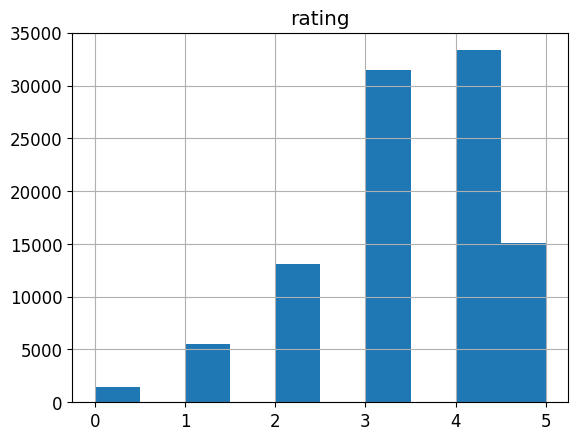

In [43]:
data.hist()

In [44]:
avarage_rantings = data[['movieId', 'rating', 'title']].groupby('title')['rating'].agg(['mean', 'count'])
avarage_rantings.columns = ['mean', 'total']
avarage_rantings = avarage_rantings.reset_index()
avarage_rantings

,title,mean,total
0,'Round Midnight (1986),3.000000,1
1,'Til There Was You (1997),2.250000,4
2,"'burbs, The (1989)",2.928571,14
3,(500) Days of Summer (2009),3.378378,37
4,*batteries not included (1987),3.000000,12
...,...,...,...
9185,loudQUIETloud: A Film About the Pixies (2006),4.000000,1
9186,xXx (2002),2.950000,20
9187,xXx: State of the Union (2005),2.666667,3
9188,Â¡Three Amigos! (1986),3.138889,36


In [45]:
avarage_rantings['total'].mode()[0]

1

In [46]:
avarage_rantings['total'].mean()

10.88139281828074

In [47]:
top_10 = avarage_rantings.loc[avarage_rantings['total'] > 120].nlargest(10, columns=['mean', 'total'])
top_10

,title,mean,total
7294,"Shawshank Redemption, The (1994)",4.358209,335
3354,"Godfather, The (1972)",4.276596,235
8620,"Usual Suspects, The (1995)",4.177686,242
3355,"Godfather: Part II, The (1974)",4.158228,158
7382,"Silence of the Lambs, The (1991)",4.154762,336
7125,Schindler's List (1993),4.148148,270
6584,Pulp Fiction (1994),4.104558,373
7695,Star Wars: Episode IV - A New Hope (1977),4.098639,294
6065,One Flew Over the Cuckoo's Nest (1975),4.085526,152
3424,Goodfellas (1990),4.064286,140


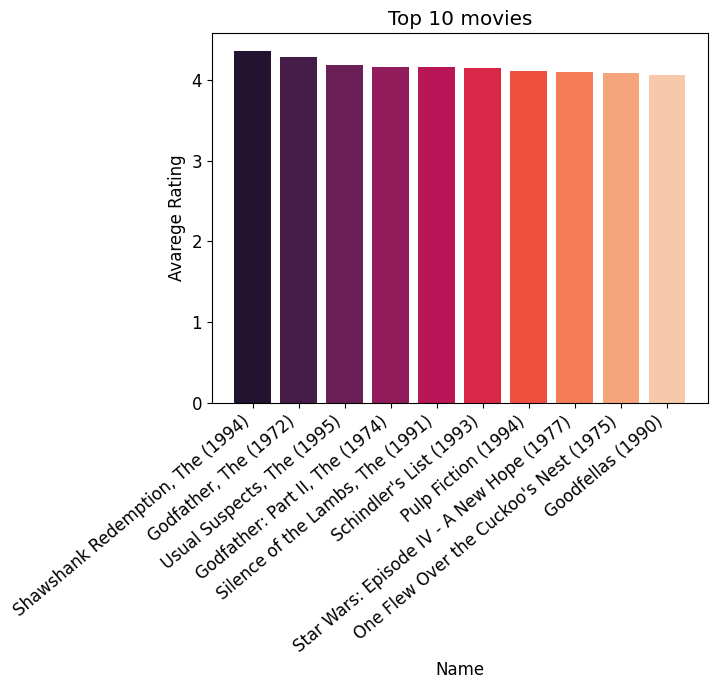

In [48]:
import matplotlib.pyplot as plt
palette = sns.color_palette('rocket', len(top_10))
plt.bar(top_10['title'], top_10['mean'], color=palette)
plt.title('Top 10 movies')
plt.xlabel('Name')
plt.ylabel('Avarege Rating')
plt.xticks(rotation=40, ha="right")
plt.show()

# Making the Dataloaders

In [49]:
dls = CollabDataLoaders.from_df(data,item_name='title', bs=64)
dls.show_batch()

,userId,title,rating
0,1238,Monty Python and the Holy Grail (1975),4
1,784,Futurama: The Beast with a Billion Backs (2008),3
2,512,Minority Report (2002),3
3,1249,Back to the Future (1985),2
4,1348,Chicago (2002),4
5,1206,Seven (a.k.a. Se7en) (1995),3
6,768,Terminator 2: Judgment Day (1991),4
7,451,"Lion King, The (1994)",5
8,586,Couples Retreat (2009),3
9,686,Young Guns (1988),4


In [50]:
n_users  = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5

print(f'Number of users: {n_users}')
print(f'Number of movies: {n_movies}')
print(f'Number of factors: {n_factors}')

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

print(f'User factors shape: {user_factors.shape}')
print(f'Movie factors shape: {movie_factors.shape}')

Number of users: 1438
Number of movies: 9191
Number of factors: 5
User factors shape: torch.Size([1438, 5])
Movie factors shape: torch.Size([9191, 5])


# Collaborative Filtering from Scratch

In [51]:
class DotProduct(Module):
    def __init__(self, n_users, n_books, n_factors,y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.book_factors = Embedding(n_books, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        return sigmoid_range((users * books).sum(dim=1), *self.y_range)

In [52]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [53]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.054407,1.041227,00:08
1,0.880869,0.937448,00:08
2,0.576787,0.940842,00:08
3,0.327021,0.951845,00:08
4,0.218222,0.957483,00:08


In [54]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [55]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.976089,0.932045,00:09
1,0.764594,0.857644,00:09
2,0.464730,0.893354,00:09
3,0.246924,0.911067,00:09
4,0.142872,0.916421,00:09


In [56]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.946266,0.934858,00:09
1,0.813130,0.857229,00:09
2,0.477660,0.894670,00:09
3,0.252720,0.916344,00:09
4,0.151888,0.922676,00:09


# Using FastAi with everything we can, Bias, Weight Decay, Layers, Embadding

In [57]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.957910,0.933988,00:09
1,0.800587,0.856783,00:09
2,0.523485,0.891566,00:09
3,0.255547,0.915418,00:09
4,0.154750,0.920677,00:09


In [58]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(1438, 50)
  (i_weight): Embedding(9191, 50)
  (u_bias): Embedding(1438, 1)
  (i_bias): Embedding(9191, 1)
)

In [59]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.001)

epoch,train_loss,valid_loss,time
0,0.998651,0.948580,00:11
1,0.891242,0.870713,00:11
2,0.782800,0.854719,00:11
3,0.697871,0.866501,00:11
4,0.648397,0.889444,00:11


# Making a Application for the Model

In [60]:
learn.export('movie_recommendation.pkl')

In [62]:
ratings.shape

(131071, 5)

In [63]:
test = ratings.drop(data.index)

In [64]:
test.shape

(31071, 5)

In [82]:
seed = 42
test = test.sample(100,random_state=seed)

In [83]:
test.shape

(100, 5)

In [84]:
test.to_csv('/kaggle/working/test.csv', index=False)

In [86]:
ratings.to_csv('/kaggle/working/ratings_test.csv', index=False)

# HuggingFace Application
https://huggingface.co/spaces/fastaioncampus/MovieRecommendation

## Some UserId for test if you want 193 1217 919 